In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Projects/Garbage-Classification/")

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [4]:
#!pip install --no-cache-dir -I pillow
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
import torchvision
from torch.autograd import Variable 
from torchvision import transforms
from tqdm import tqdm

In [6]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [0]:
# torch vision transform to preprocessinbg data
data_dir = "GARBAGES"
input_shape = 224
batch_size = 64
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
scale = 360
use_parallel = False
use_gpu = False
epochs = 15

data_transforms = transforms.Compose([
        transforms.Resize(scale),
        transforms.RandomResizedCrop(input_shape),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

In [0]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [10]:
len(class_names)

6

In [11]:
imgs, _ = next(iter(dataloaders['train']))
print("size of input batch: ", imgs.shape)

size of input batch:  torch.Size([64, 3, 224, 224])


In [0]:
def flatten(x):
    n = x.shape[0]
    return x.view(n, -1)

In [0]:
import torch.nn.functional as F

In [0]:
class ConvNetSimple(nn.Module):
    def __init__(self, nb_channel_in, nb_channel1, nb_channel2, num_classe):
        super().__init__()
        self.conv1 = nn.Conv2d(nb_channel_in, nb_channel1, kernel_size=5, padding=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0)
        
        self.conv2 = nn.Conv2d(nb_channel1, nb_channel2, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0)
        
        self.bnconv2 = nn.BatchNorm2d(nb_channel2)
        
        self.fc1 = nn.Linear(in_features=nb_channel2*56*56, out_features=1000)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        
        self.fc2 = nn.Linear(in_features=1000, out_features=len(class_names))
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
        
        self.bnlinear = nn.BatchNorm1d(1000)
        
    def forward(self, x):
        #x = F.relu(self.conv1(x))
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x,2))
        x = self.conv2(x)
        x = self.bnconv2(x)
        x = F.relu(F.max_pool2d(x,2))
        
        #x = self.bnconv2(x)
        x = flatten(x)
        x = F.relu( self.bnlinear( self.fc1(x) ) )
        x = F.relu( self.fc2(x) )
        
        return x        

In [0]:
#optim.SGD?

In [0]:
import time

def train(model, use_gpu):
    
    # 2.setup graphs
    train_loss=[]
    train_accuracy=[]
    valid_loss=[]
    valid_accuracy=[]
    
    # 3.create criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    # 1.move the model parameters to CPU/GPU and set time
    if use_gpu:
        model.cuda()
        criterion.cuda()
    since = time.time()
    
    # 4.create scheduler
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    # 6.model saving
    best_valid_acc = 0
    best_model = model.state_dict()
    
    # 5.train
    print("[Training the model begun ....]")
    for e in range(epochs):
        print("Epoch {}/{}".format(e, epochs-1))
        print('-'*10)
        
        running_loss = 0.0
        running_corrects = 0
        
        # Set model to training mode
        model.train()
        
        # Iterate over data
        for inputs, labels in tqdm(dataloaders['train']):
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            
            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()
            
            # forward and loss
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            
            # This is the backwards pass: compute the gradient of the loss with respect to each parameter of the model.
            loss.backward()
            optimizer.step()
    
            running_loss +=loss.item()
            running_corrects += int(torch.sum(preds == labels))
        
        epoch_train_loss = running_loss / dataset_sizes['train']
        epoch_train_acc = running_corrects / dataset_sizes['train']
        print("train loss: {:.4f}   train acc: {:.4f}".format(epoch_train_loss, epoch_train_acc))
        
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        
        running_loss_val = 0.0
        running_corrects_val = 0
        model.eval()
        for inputs, labels in tqdm(dataloaders['val']):
            #model.eval()
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            valid_score = model(inputs)
            _, preds = torch.max(valid_score,1)
            validation_loss = criterion(valid_score, labels)
            running_loss_val += validation_loss.item()
            running_corrects_val += int(torch.sum(preds == labels))
        epoch_valid_loss = running_loss_val / dataset_sizes['val']
        epoch_valid_acc = running_corrects_val / dataset_sizes['val']
        valid_loss.append(epoch_valid_loss)
        valid_accuracy.append(epoch_valid_acc)
        print("valid loss: {:.4f}   valid acc: {:.4f}".format(epoch_valid_loss, epoch_valid_acc))
        
        # deep copy the model
        if epoch_valid_acc > best_valid_acc:
            best_valid_acc = epoch_valid_acc
            best_model = model.state_dict()
        
        #scheduler.step(validation_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    # load best model weights
    model.load_state_dict(best_model)
    return model, (train_loss, train_accuracy, valid_loss, valid_accuracy)
        

In [17]:
model = ConvNetSimple(3, 16, 8, len(class_names))
best_model, stats = train(model, True)

  0%|          | 0/28 [00:00<?, ?it/s]

[Training the model begun ....]
Epoch 0/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0268   train acc: 0.3043


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0276   valid acc: 0.2490
Epoch 1/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0239   train acc: 0.4077


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0250   valid acc: 0.3913
Epoch 2/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0230   train acc: 0.4337


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0226   valid acc: 0.4190
Epoch 3/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0225   train acc: 0.4416


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0235   valid acc: 0.4308
Epoch 4/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0217   train acc: 0.4613


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0237   valid acc: 0.4032
Epoch 5/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0216   train acc: 0.4647


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0212   valid acc: 0.4862
Epoch 6/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0208   train acc: 0.5116


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0206   valid acc: 0.5375
Epoch 7/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0208   train acc: 0.5144


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0204   valid acc: 0.5020
Epoch 8/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0203   train acc: 0.5274


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0194   valid acc: 0.4980
Epoch 9/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0199   train acc: 0.5274


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0197   valid acc: 0.5494
Epoch 10/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0193   train acc: 0.5426


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0197   valid acc: 0.5296
Epoch 11/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0193   train acc: 0.5426


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0220   valid acc: 0.4862
Epoch 12/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0192   train acc: 0.5415


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0193   valid acc: 0.5573
Epoch 13/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0186   train acc: 0.5686


  0%|          | 0/28 [00:00<?, ?it/s]

valid loss: 0.0206   valid acc: 0.5573
Epoch 14/14
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0192   train acc: 0.5488


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

valid loss: 0.0199   valid acc: 0.5296
Training complete in 6m 7s


In [0]:
#optim.lr_scheduler.ReduceLROnPlateau.step?

In [21]:
#model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0703,  0.2185, -0.1543, -0.1021, -0.0579],
                        [-0.0760,  0.3450,  0.0190,  0.0834, -0.0228],
                        [ 0.1830, -0.0804, -0.2184, -0.0051, -0.1796],
                        [ 0.2346, -0.0913,  0.0138,  0.2726,  0.0747],
                        [ 0.2308,  0.0849,  0.0299, -0.0463,  0.2052]],
              
                       [[-0.0590, -0.0427, -0.0478,  0.0123,  0.1223],
                        [-0.0784,  0.2065, -0.0274, -0.0328, -0.0243],
                        [ 0.0997, -0.0078,  0.1305,  0.2413, -0.1996],
                        [ 0.1342,  0.2810, -0.0477, -0.1401,  0.0986],
                        [ 0.0606,  0.1304, -0.2387,  0.2070, -0.1020]],
              
                       [[ 0.0362,  0.0940,  0.3064,  0.0165,  0.1309],
                        [ 0.0096,  0.0455,  0.0797,  0.1339, -0.1705],
                        [-0.1111, -0.0820,  0.0906,  0.1934, -0.1450],
               

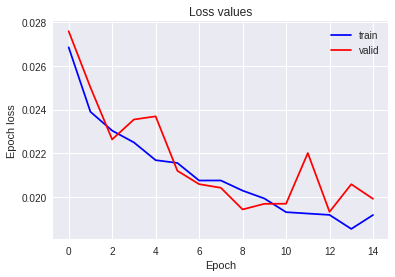

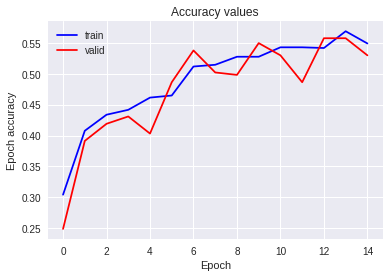

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
#Loss
x = range(15)
plt.figure()
plt.plot(x, stats[0], "b", label="train")
plt.plot(x, stats[2], "r", label="valid")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Epoch loss")
plt.legend()
#plt.savefig("Loss.png")
plt.show()
#Accu
x = range(15)
plt.figure()
plt.plot(x, stats[1], "b", label="train")
plt.plot(x, stats[3], "r", label="valid")
plt.title("Accuracy values")
plt.xlabel("Epoch")
plt.ylabel("Epoch accuracy")
plt.legend()
#plt.savefig("Accu.png")
plt.show()

In [22]:
# test prediction score

best_model.eval()
best_model.cuda()
running_test = 0
for x_batch, y_batch in tqdm(dataloaders['test']):
    
    x_batch = x_batch.cuda()
    y_batch = y_batch.cuda()
    
    out = best_model(x_batch)
    _, preds = torch.max(out, 1)
    running_test += int(torch.sum(preds == y_batch))
test_score = running_test / dataset_sizes['test']
print("test accuracy is {:.4f}".format(test_score))
    


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

test accuracy is 0.5556
